In [1]:
import sys,os
os.chdir('../../')
sys.path.append('./src/data')
sys.path.append('./src/events')
sys.path.append('./src/probability')
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
from PINGU.importer import *
from PINGU.processer import *
from PINGU.main import get_all_events,get_events
from functions import perform_chisq
from DC.event_processing import list_of_params_nsi,get_param_list, nufit_params_nsi_IO, marginalize, marginalize_one
from PINGU.event_processing import return_precomputed_nsi, get_deltachi, to_hist,get_marginalized_array
from scipy.stats import chi2
from src.plotter import save, savethesis
import pickle
from scipy.interpolate import splrep, splev, sproot
plt.rcParams['figure.figsize'] = [8, 4]
plt.rcParams['figure.dpi'] = 100
matplotlib.rc('text', usetex=True)
matplotlib.rc('text.latex', preamble=r'\usepackage{siunitx}')
np.set_printoptions(linewidth=200)
Ebins_2018_midpoints = Ebins_2018[0:-1] +np.diff(Ebins_2018)/2

In [2]:
ndim = 3
livetime = 3*365*24*3600 #Effective livetime table1 DC2019 2.45
precomputed_events = True
IO=False
ordering = 'IO' if IO else 'NO'
ett = 7e-2
emt = 3e-2
eem = 3e-1
eet = 3e-1
dm31_range, th23_range,ett_range, emt_range, eem_range, eet_range = get_param_list(dm31N=5, 
                                                                                   th23N=5, 
                                                                          ett_tuple=(-ett,ett,1), 
                                                                          emt_tuple=(-emt,emt,10), 
                                                                          eem_tuple=(-eem,eem,1), 
                                                                          eet_tuple=(-eet,eet,1), 
                                                                          IO=IO)

print('dm:', dm31_range)
print('th:', th23_range)
print('ett:', ett_range)
print('emt:', emt_range)
print('eem:', eem_range)
print('eet:', eet_range)
param_dict = nufit_params_nsi_IO if IO else nufit_params_nsi

param_list = list_of_params_nsi(param_dict, dm31_range, th23_range, ett_range, emt_range, eem_range, eet_range)

H1 = pickle.load(open(f'./pre_computed/H1_{ordering}_PINGU_{len(dm31_range)}x{len(th23_range)}x{len(ett_range)}x{len(emt_range)}x{len(eem_range)}x{len(eet_range)}.p','rb'))*livetime
H0 = pickle.load(open(f'./pre_computed/H0_{ordering}_PINGU.p','rb'))*livetime

dm: [0.002 0.002 0.003 0.003 0.003]
th: [0.7   0.767 0.835 0.859 0.902]
ett: [0.]
emt: [-0.03  -0.022 -0.015 -0.007  0.     0.007  0.015  0.022  0.03 ]
eem: [0.]
eet: [0.]


In [4]:
sigma_a = 0.25
sigma_b = 0.04
f = 0#.05
chisq,  best_fit_index = get_deltachi([H for H in H1],H0,0,[sigma_a,sigma_b],f,x0=[1,0])
deltachi, best_dm31_index, best_th23_index, best_ett_index, best_emt_index, best_eem_index, best_eet_index = marginalize(chisq,dm31_range, th23_range, ett_range, emt_range, eem_range, eet_range)

best_dm31, best_th23, best_ett, best_emt, best_eem, best_eet = (dm31_range[best_dm31_index], 
                                                                th23_range[best_th23_index],
                                                                ett_range[best_ett_index],
                                                                emt_range[best_emt_index],
                                                                eem_range[best_eem_index],
                                                                eet_range[best_eet_index])
best_fit_params = param_list[best_fit_index]

if len(eem_range) > 1 and len(eet_range) > 1:
    if len(emt_range) > 1:
        deltachi_eem_eet = marginalize_one(chisq.reshape(9,9,9), axis=2)
        deltachi_emt_eet = marginalize_one(chisq.reshape(9,9,9), axis=1)
        deltachi_emt_eem = marginalize_one(chisq.reshape(9,9,9), axis=0)
    else:
        deltachi_nomarg_eem_eet = deltachi
elif len(emt_range) > 1 and len(eet_range) > 1:
    deltachi_nomarg_emt_eet = deltachi
elif len(emt_range) > 1 and len(eem_range) > 1:
    deltachi_nomarg_emt_eem = deltachi
if len(emt_range) > 1:
    deltachi_emt = deltachi

In [10]:
from PINGU.event_processing import get_marginalized_array
P_chisq = get_marginalized_array(H1,H0,dm31_range,th23_range,ett_range,emt_range,eem_range,eet_range, param_list, 'emt', sigma_a,sigma_b, f)

In [11]:
P_chisq.sha

(9,)

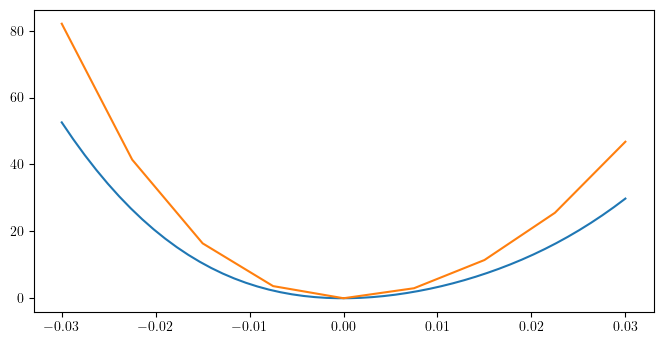

In [12]:
from scipy.interpolate import RectBivariateSpline
finer_e_range = np.linspace(-emt,emt,50)
interpolated_e = splev(finer_e_range,splrep(emt_range, deltachi_emt.reshape(-1)))

plt.plot(finer_e_range, interpolated_e)
plt.plot(emt_range, P_chisq)

In [ ]:
from scipy.interpolate import RectBivariateSpline
x = eem_range
y = eet_range
spl = RectBivariateSpline(x,y,deltachi.reshape(9,9))
x_fine = np.linspace(x.min(),x.max(),50)
y_fine = np.linspace(y.min(),y.max(),50)
z = spl(x_fine, y_fine)
fig, ax = plt.subplots(1,1,figsize=(4,4))

im = ax.contour(x_fine,y_fine,z, levels=[chi2.ppf(0.9,2),chi2.ppf(0.9973,2)],colors=['b','b'], linestyles = ['solid','dashed'])
ax.set_xlabel(r'$\epsilon_{e\mu}$', fontsize=20)
ax.set_ylabel(r'$\epsilon_{\tau\tau}$', fontsize=20)


fmt_noerr = {}
strs = ['90\% CL', r'$3\sigma$']
for l, s in zip(im.levels, strs):
    fmt_noerr[l] = s
ax.clabel(im, im.levels, inline=True, fmt=fmt_noerr, fontsize=10)
#save(fig,'PINGU_2D_eem_ett')

No handles with labels found to put in legend.


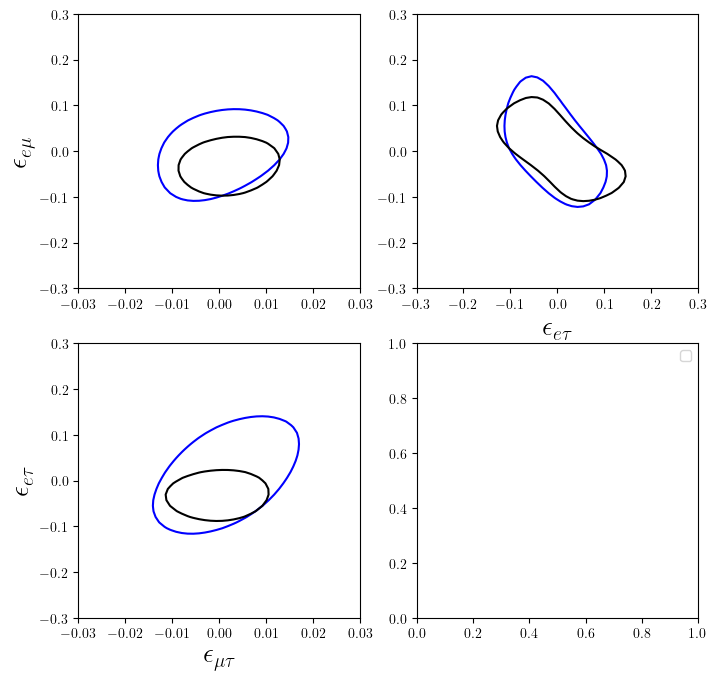

In [57]:
from scipy.interpolate import RectBivariateSpline
x = eem_range
y = eet_range
eem_fine = np.linspace(-eem,eem,50)
eet_fine = np.linspace(-eet,eet,50)
emt_fine = np.linspace(-emt,emt,50)

spl_nomarg_emt_eem = RectBivariateSpline(emt_range,eem_range,deltachi_nomarg_emt_eem.reshape(9,9))
spl_nomarg_eem_eet = RectBivariateSpline(eem_range,eet_range,deltachi_nomarg_eem_eet.reshape(9,9))
spl_nomarg_emt_eet = RectBivariateSpline(emt_range,eet_range,deltachi_nomarg_emt_eet.reshape(9,9))

spl_emt_eem = RectBivariateSpline(emt_range,eem_range,deltachi_emt_eem)
spl_eem_eet = RectBivariateSpline(eem_range,eet_range,deltachi_eem_eet)
spl_emt_eet = RectBivariateSpline(emt_range,eet_range,deltachi_emt_eet)

z_nomarg_emt_eem = spl_nomarg_emt_eem(emt_fine,eem_fine)
z_nomarg_eem_eet = spl_nomarg_eem_eet(eem_fine,eet_fine)
z_nomarg_emt_eet = spl_nomarg_emt_eet(emt_fine,eet_fine)

z_emt_eem = spl_emt_eem(emt_fine,eem_fine)
z_eem_eet = spl_eem_eet(eem_fine,eet_fine)
z_emt_eet = spl_emt_eet(emt_fine,eet_fine)
fig, ax = plt.subplots(2,2,figsize=(4*2,4*2))


ax[0,0].contour(emt_fine,eem_fine,z_nomarg_emt_eem, levels=[chi2.ppf(0.9,2)],colors=['b','b'], linestyles = ['solid','dashed'])
im_emt_eem = ax[0,0].contour(emt_fine,eem_fine,z_emt_eem, levels=[chi2.ppf(0.9,2)],colors=['k','k'], linestyles = ['solid','dashed'])

ax[0,1].contour(eet_fine,eem_fine,z_nomarg_eem_eet, levels=[chi2.ppf(0.9,2)],colors=['b','b'], linestyles = ['solid','dashed'])
im_eem_eet = ax[0,1].contour(eet_fine,eem_fine,z_eem_eet.T, levels=[chi2.ppf(0.9,2)],colors=['k','k'], linestyles = ['solid','dashed'])

ax[1,0].contour(emt_fine,eet_fine,z_nomarg_emt_eet, levels=[chi2.ppf(0.9,2)],colors=['b','b'], linestyles = ['solid','dashed'])
im_emt_eet = ax[1,0].contour(emt_fine,eet_fine,z_emt_eet, levels=[chi2.ppf(0.9,2)],colors=['k','k'], linestyles = ['solid','dashed'])

ax[0,0].set_ylabel(r'$\epsilon_{e\mu}$', fontsize=20)

ax[0,1].set_xlabel(r'$\epsilon_{e\tau}$', fontsize=20)

ax[1,0].set_xlabel(r'$\epsilon_{\mu\tau}$', fontsize=20)
ax[1,0].set_ylabel(r'$\epsilon_{e\tau}$', fontsize=20)
plt.legend()

fmt_noerr = {}
strs = ['90\% CL', r'$3\sigma$']
for l, s in zip(im_nomarg.levels, strs):
    fmt_noerr[l] = s
#ax.clabel(im, im.levels, inline=True, fmt=fmt_noerr, fontsize=10)
#save(fig,'PINGU_2D_eem_ett')

In [22]:
marginalized_arrays_NO=[]
marginalized_arrays_IO=[]
nsi_param_range=[]
N = 10 - 1
sigma_a = 0.25
sigma_b = 0.04
f = 0#.05
for ordering in ['NO']:
    for i,nsi_param in enumerate(['ett','emt','eem','eet']):
        for j,nsi_param2 in enumerate(['ett','emt','eem','eet']):
            ettN,emtN,eemN,eetN = 0,0,0,0
            if nsi_param == 'ett' or nsi_param2 == 'ett':
                ettN = 1
            if nsi_param == 'emt' or nsi_param2 == 'emt':
                emtN = 1
            if nsi_param == 'eem' or nsi_param2 == 'eem':
                eemN = 1
            if nsi_param == 'eet' or nsi_param == 'eet':
                eetN = 1
            dm31_range, th23_range,ett_range, emt_range, eem_range, eet_range = get_param_list(dm31N=1, th23N=1, 
                                                                            ett_tuple=(-ett,ett,N*(ettN)+1), 
                                                                            emt_tuple=(-emt,emt,N*(emtN)+1), 
                                                                            eem_tuple=(-eem,eem,N*(eemN)+1), 
                                                                            eet_tuple=(-eet,eet,N*(eetN)+1), 
                                                                            IO = True if ordering == 'IO' else False)

            param_dict = nufit_params_nsi_IO if ordering == 'IO' else nufit_params_nsi     
            param_list = list_of_params_nsi(param_dict, dm31_range, th23_range,ett_range, emt_range, eem_range,eet_range) 
            try:
                H1 = pickle.load(open(f'./pre_computed/H1_{ordering}_PINGU_{len(dm31_range)}x{len(th23_range)}x{len(ett_range)}x{len(emt_range)}x{len(eem_range)}x{len(eet_range)}.p','rb'))*livetime
                H0 = pickle.load(open(f'./pre_computed/H0_{ordering}_PINGU.p','rb'))*livetime
                print(nsi_param, nsi_param2)
                chisq,  best_fit_index = get_deltachi([H for H in H1],H0,0,[sigma_a,sigma_b],f,x0=[1,0])

                reshaped_chisq = chisq.reshape(len(eet_range),
                                            len(eem_range),
                                            len(emt_range), 
                                            len(ett_range), 
                                            len(th23_range), 
                                            len(dm31_range)) #reshaped_chisq[eet,eem,emt,emm,th23,dm31]
                minimum_oscillation = np.min(reshaped_chisq,axis=(0,1,2,3)).reshape(1,1,1,1,len(th23_range),len(dm31_range)) #Marginalize osc params
                deltachi = reshaped_chisq - minimum_oscillation

                marginalized_deltachi = deltachi[:,:,:,:,0,0].T
                if ordering == 'NO':
                    marginalized_arrays_NO.append(marginalized_deltachi)
                elif ordering == 'IO':
                    marginalized_arrays_IO.append(marginalized_deltachi)
                param_range = ettN*ett_range + emtN*emt_range + eemN*eem_range + eetN*eet_range #Assumes 3d plot
                nsi_param_range.append(param_range)
            except FileNotFoundError:
                pass #No IO found

ett emt
ett eem
emt ett
emt eem
eem ett
eem emt
eet ett
eet emt
eet eem


In [24]:
del marginalized_arrays_NO[2]
del marginalized_arrays_NO[3]
del marginalized_arrays_NO[3]

Text(0.5, 0.98, '$f=0\\%$')

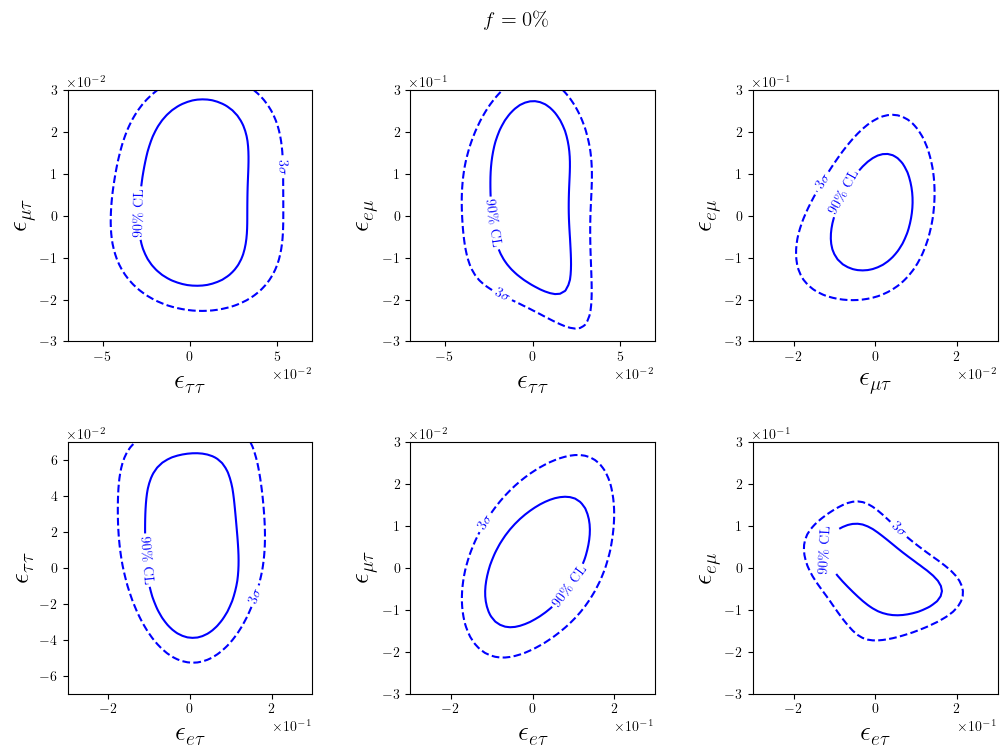

In [26]:
from scipy.interpolate import RectBivariateSpline
fig, ax = plt.subplots(2,3,figsize=(4*3,4*2))
ax = ax.flatten()

labels = [(r'$\epsilon_{\tau\tau}$', r'$\epsilon_{\mu\tau}$'), (r'$\epsilon_{\tau\tau}$', r'$\epsilon_{e\mu}$'),
          (r'$\epsilon_{\mu\tau}$', r'$\epsilon_{e\mu}$'), 
          (r'$\epsilon_{e\tau}$', r'$\epsilon_{\tau\tau}$'), (r'$\epsilon_{e\tau}$', r'$\epsilon_{\mu\tau}$'),
          (r'$\epsilon_{e\tau}$', r'$\epsilon_{e\mu}$')]
x_ranges = [np.linspace(-ett,ett,9), np.linspace(-ett,ett,9),
            np.linspace(-emt,emt,9),
            np.linspace(-eet,eet,9), np.linspace(-eet,eet,9), np.linspace(-eet,eet,9)]
y_ranges = [np.linspace(-emt,emt,9), np.linspace(-eem,eem,9),
            np.linspace(-eem,eem,9), np.linspace(-ett,ett,9),
            np.linspace(-emt,emt,9), np.linspace(-eem,eem,9)]
for i, array in enumerate(marginalized_arrays_NO):
    dchi = array.reshape(9,9)
    x = x_ranges[i]
    y = y_ranges[i]
    spl = RectBivariateSpline(x,y,dchi)
    x_fine = np.linspace(x.min(),x.max(),50)
    y_fine = np.linspace(y.min(),y.max(),50)
    z = spl(x_fine, y_fine)
    

    im = ax[i].contour(x_fine,y_fine,z, levels=[chi2.ppf(0.9,2),chi2.ppf(0.9973,2)],colors=['b','b'], linestyles = ['solid','dashed'])
    ax[i].set_xlabel(labels[i][0], fontsize=20)
    ax[i].set_ylabel(labels[i][1], fontsize=20)
    ax[i].ticklabel_format(axis="both", style="sci", scilimits=(0,0))


    fmt_noerr = {}
    strs = ['90\% CL', r'$3\sigma$']
    for l, s in zip(im.levels, strs):
        fmt_noerr[l] = s
    ax[i].clabel(im, im.levels, inline=True, fmt=fmt_noerr, fontsize=10)
plt.subplots_adjust(wspace = 0.4, hspace=0.4)
plt.suptitle(r'$f=0\%$', fontsize = 15)
#save(fig,'PINGU_2D_all_f0')

$\epsilon_{\tau\tau}$
90CL: [-0.027  0.056]
3sigma: [-0.045]

$\epsilon_{\mu\tau}$
90CL: [-0.004  0.004]
3sigma: [-0.008  0.011]

$\epsilon_{e\mu}$
90CL: [-0.034  0.03 ]
3sigma: [-0.091  0.071]

$\epsilon_{e\tau}$
90CL: [-0.039  0.045]
3sigma: [-0.092  0.108]



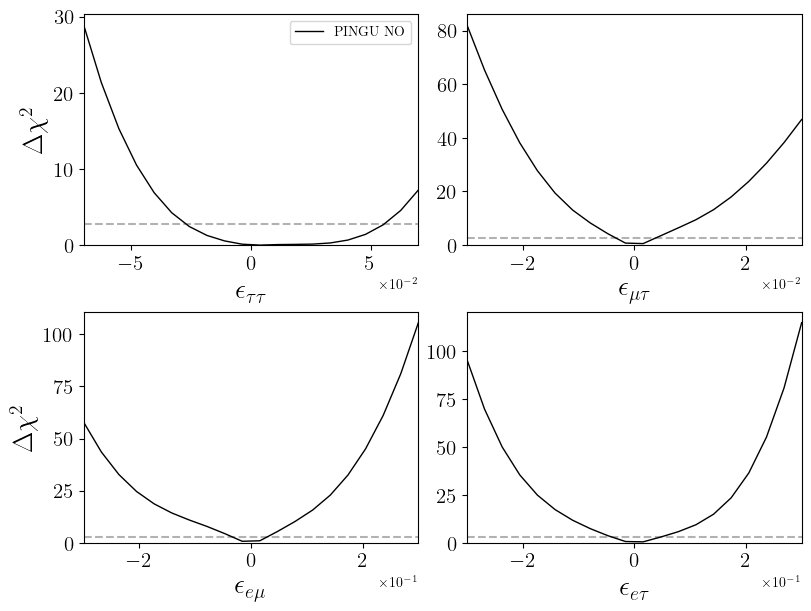

In [15]:
fig, ax = plt.subplots(2,2,figsize=(8,6), constrained_layout=True)
ax = ax.flatten()
demidov_ett = (-0.055, 0.056)
demidov_emt = (-0.023, 0.016)
demidov_eem = (-0.21, 0.20)
demidov_eet = (-0.19, 0.20)
xlabels = [r'$\epsilon_{\tau\tau}$', r'$\epsilon_{\mu\tau}$', r'$\epsilon_{e\mu}$', r'$\epsilon_{e\tau}$']
demidovs =[demidov_ett, demidov_emt, demidov_eem, demidov_eet]
for i in range(4):
    finer_e_range = np.linspace(nsi_param_range[i].min(),nsi_param_range[i].max(),20)
    interpolated_e = splev(np.linspace(nsi_param_range[i].min(),nsi_param_range[i].max(),20),splrep(nsi_param_range[i], marginalized_arrays_NO[i]))
    
    ax[i].plot(finer_e_range, interpolated_e, label='PINGU NO', color='k', lw=1)

    ax[i].axhline(chi2.ppf(0.9,1), alpha=0.3, c='black', ls = '--')

    #ax[i].axvline(demidovs[i][0], alpha=0.6,c='black', label=r'Demidov NO')
    #ax[i].axvline(demidovs[i][1], alpha=0.6,c='black')
    ax[i].set_ylim(bottom=0)
    ax[i].set_xlim((nsi_param_range[i].min(), nsi_param_range[i].max()))
    ax[i].set_xlabel(xlabels[i], fontsize=20)
    ax[i].tick_params(labelsize=15)
    ax[i].ticklabel_format(axis="x", style="sci", scilimits=(0,0))
    cl_90_bounds = splrep(nsi_param_range[i], marginalized_arrays_NO[i]- chi2.ppf(0.9,1))
    three_sigma_bounds = splrep(nsi_param_range[i], marginalized_arrays_NO[i]- chi2.ppf(0.9973,1))
    print(xlabels[i]+'\n'+f'90CL: {sproot(cl_90_bounds)}\n'+f'3sigma: {sproot(three_sigma_bounds)}\n')
ax[0].set_ylabel(r'$\Delta \chi^2$', fontsize=20)
ax[2].set_ylabel(r'$\Delta \chi^2$', fontsize=20)
ax[0].legend()
#save(fig, 'PINGU_3D_NO')
#savethesis(fig, 'PINGU_3D_NO')

In [16]:
H1_PINGU = [pickle.load(open(f'./pre_computed/H1_NO_PINGU_5x5x9x1x1x1.p','rb'))*livetime,
            pickle.load(open(f'./pre_computed/H1_NO_PINGU_5x5x1x9x1x1.p','rb'))*livetime,
            pickle.load(open(f'./pre_computed/H1_NO_PINGU_5x5x1x1x9x1.p','rb'))*livetime,
            pickle.load(open(f'./pre_computed/H1_NO_PINGU_5x5x1x1x1x9.p','rb'))*livetime]
H1_DC = [pickle.load(open(f'./pre_computed/H1_NO_DC_5x5x9x1x1x1.p','rb'))*livetime,
         pickle.load(open(f'./pre_computed/H1_NO_DC_5x5x1x9x1x1.p','rb'))*livetime,
         pickle.load(open(f'./pre_computed/H1_NO_DC_5x5x1x1x9x1.p','rb'))*livetime,
         pickle.load(open(f'./pre_computed/H1_NO_DC_5x5x1x1x1x9.p','rb'))*livetime]
H0_PINGU = pickle.load(open(f'./pre_computed/H0_NO_PINGU.p','rb'))*livetime
H0_DC = pickle.load(open(f'./pre_computed/H0_NO_DC.p','rb'))*livetime
H1_IC = [pickle.load(open(f'./pre_computed/H1_NO_IC_N13_5x5x9.p','rb'))*livetime]
H0_IC = pickle.load(open(f'./pre_computed/H0_IC_N13.p','rb'))

FileNotFoundError: [Errno 2] No such file or directory: './pre_computed/H1_NO_DC_5x5x9x1x1x1.p'

<ipython-input-80-8f163e4a321e>:17: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax[i][pid].pcolormesh(zbins_2018[0:5],Ebins_2018, pulls[pid], cmap='RdBu', vmin = -1, vmax=1, shading='auto')


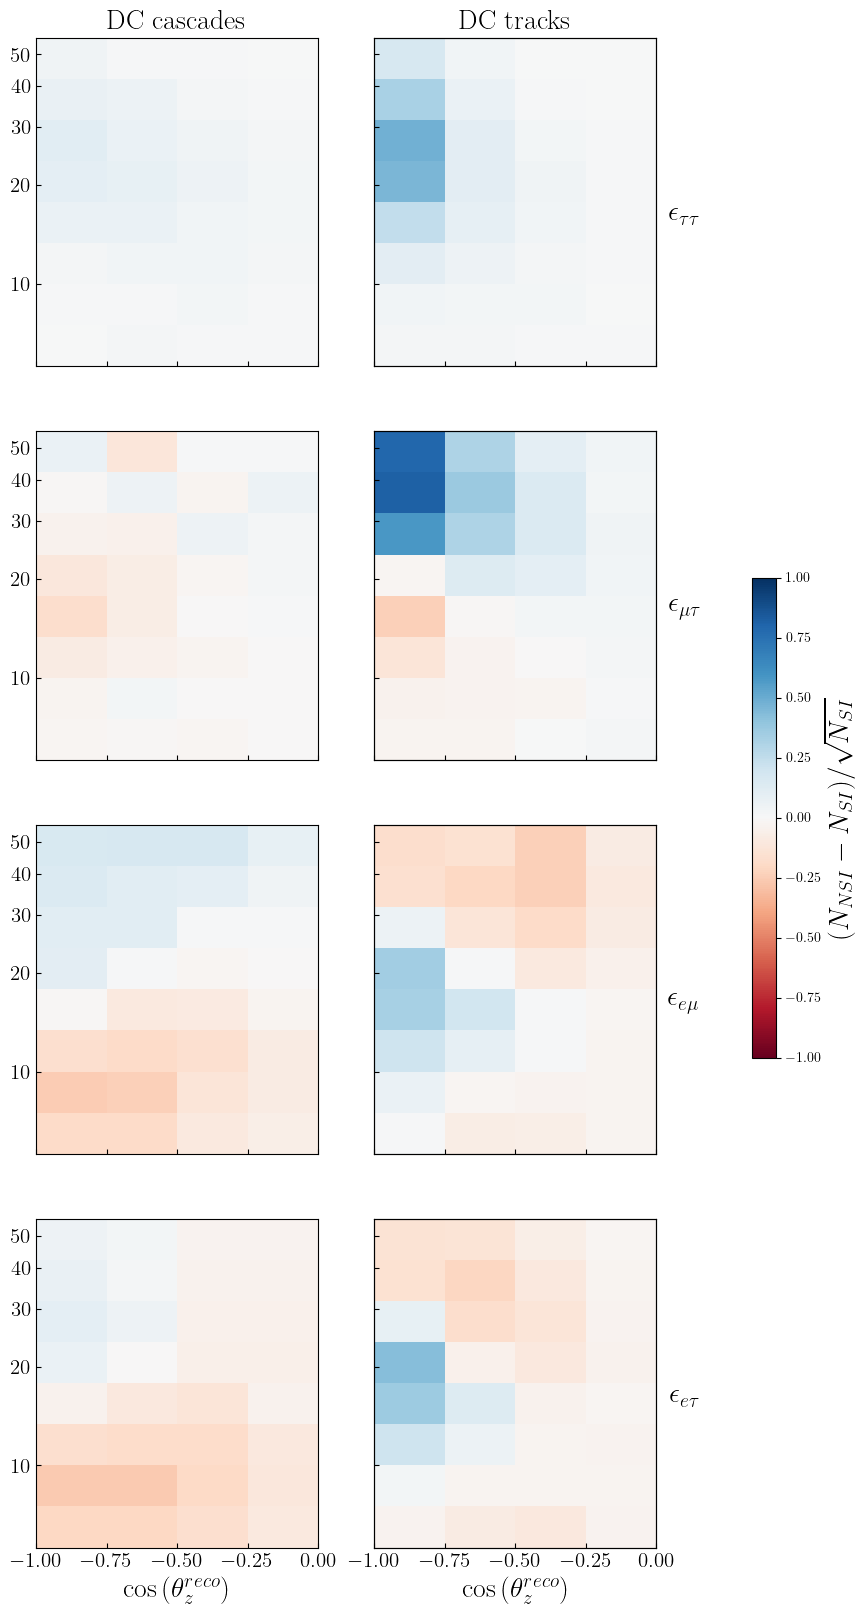

In [80]:
from matplotlib.colors import CenteredNorm
from matplotlib import gridspec
fig, ax = plt.subplots(4,4,figsize=(8,20),sharex=True, sharey=True, squeeze=True)
titles = [r'$\epsilon_{\tau\tau}$', r'$\epsilon_{\mu\tau}$', r'$\epsilon_{e\mu}$', r'$\epsilon_{e\tau}$']
left_index = 67
right_index = 167
assert np.isclose(param_list[left_index]['e_mt'], -0.01)
assert np.isclose(param_list[right_index]['e_mt'], 0.01)

for i in range(4):
    N_NSI_left_DC = H1_DC[i][left_index,:,:,0:5]
    N_SI_DC = H0_DC[:,:,0:5] #H0
    pull_minDC = (N_NSI_left_DC - N_SI_DC)/np.sqrt(N_SI_DC)
    pullsDC = [pull_minDC[0], pull_minDC[1]]

    N_NSI_left_PINGU = H1_PINGU[i][left_index,:,:,0:5]
    N_SI_PINGU = H0_PINGU[:,:,0:5] #H0
    pull_minPINGU = (N_NSI_left_PINGU - N_SI_PINGU)/np.sqrt(N_SI_PINGU)
    pullsPINGU = [pull_minPINGU[0], pull_minPINGU[1]]
    



    for pid in [0,1]:
        #ax[i][pid].set_title(titles[pid], fontsize=20)
        imDC = ax[i+2][pid].pcolormesh(zbins_2018[0:5],Ebins_2018, pullsDC[pid], cmap='RdBu', vmin = -1, vmax=1, shading='auto')
        imPINGU = ax[i][pid].pcolormesh(zbins_2018[0:5],Ebins_2018, pullsPINGU[pid], cmap='RdBu', vmin = -1, vmax=1, shading='auto')
        ax[i+2][pid].set_yscale('log')
        ax[i][pid].set_yscale('log')
        
        
        ax[i][pid].set_yticks([], minor=True)
        ax[i][pid].get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
        ax[i][pid].get_yaxis().set_minor_formatter(matplotlib.ticker.ScalarFormatter())
        #ax[pid].ticklabel_format(style='sci',axis='y')
        ax[i][pid].tick_params(which='both',labelsize=15)
        ax[i][pid].set_yticks(np.linspace(10,50,5))
        ax[i][pid].set_xticks(zbins_2018[0:5])
        ax[i][pid].tick_params(axis='both', direction='in', which='both')

        ax[i+2][pid].set_yticks([], minor=True)
        ax[i+2][pid].get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
        ax[i+2][pid].get_yaxis().set_minor_formatter(matplotlib.ticker.ScalarFormatter())
        #ax[pid].ticklabel_format(style='sci',axis='y')
        ax[i+2][pid].tick_params(which='both',labelsize=15)
        ax[i+2][pid].set_yticks(np.linspace(10,50,5))
        ax[i+2][pid].set_xticks(zbins_2018[0:5])
        ax[i+2][pid].tick_params(axis='both', direction='in', which='both')

    ax2 = ax[i+2][1].twinx()  # instantiate a second axes that shares the same x-axis
    ax2.set_yticks([])
    ax2.set_ylabel(titles[i], rotation=0, fontsize=20,labelpad=20)

cax = fig.add_axes([0.85, 0.1, 0.2, 0.78])
plt.colorbar(imDC, ax=cax, pad=0.45)


ax[3][0].set_xlabel(r'$\cos{(\theta^{reco}_z)}$', fontsize=20)
ax[3][1].set_xlabel(r'$\cos{(\theta^{reco}_z)}$', fontsize=20)
ax2 = cax.twinx()
ax2.set_yticks([])
_=ax2.set_ylabel(r'$(N_{NSI} - N_{SI})/\sqrt{N_{SI}}$', fontsize=20, labelpad= 105)
_=cax.axis('off')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax[0][0].set_title(r'PINGU cascades', fontsize=20)
ax[1][1].set_title(r'PINGU tracks', fontsize=20)
ax[2][0].set_title(r'DC cascades', fontsize=20)
ax[3][1].set_title(r'DC tracks', fontsize=20)
#plt.savefig('./article/figures/DC_event_pulls.pdf', bbox_inches="tight")

<ipython-input-11-e2dab9c071ba>:31: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im_DC = ax[0].pcolormesh(zbins_2018[0:5],Ebins_2018, np.log10(pull_ratio_DC),cmap='RdBu',vmin = np.log10(0.96), vmax=np.log10(1.04))
<ipython-input-11-e2dab9c071ba>:32: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im_PINGU = ax[1].pcolormesh(zbins_2018[0:5],Ebins_2018, np.log10(pull_ratio_PINGU), cmap='RdBu',vmin = np.log10(0.96), vmax=np.log10(1.04))


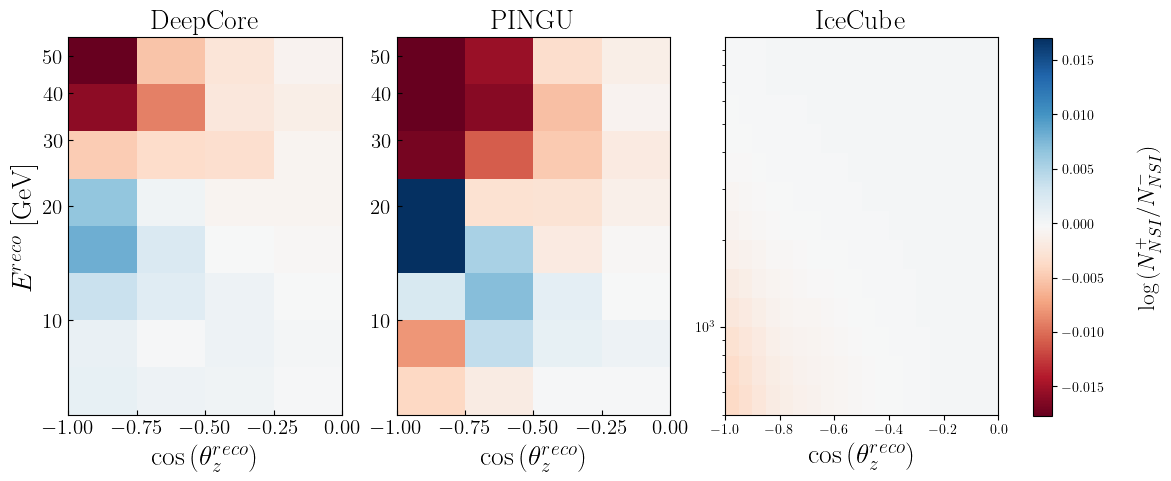

In [11]:
left_index = 67
right_index = 167
assert np.isclose(param_list[left_index]['e_mt'], -0.01)
assert np.isclose(param_list[right_index]['e_mt'], 0.01)

fig, ax = plt.subplots(1,3,figsize=(3/2*8,5), squeeze=True)
titles = [r'$\epsilon_{\tau\tau}$', r'$\epsilon_{\mu\tau}$', r'$\epsilon_{e\mu}$', r'$\epsilon_{e\tau}$']

N_NSI_left_DC = H1_DC[1][left_index,0,:,0:5] + H1_DC[1][left_index,1,:,0:5] #su tracks and cascades. pick only 4 z bins
N_NSI_left_PINGU = H1_PINGU[1][left_index,0,:,0:5] + H1_PINGU[1][left_index,1,:,0:5]
N_NSI_left_IC = H1_IC[0][left_index]

N_NSI_right_DC = H1_DC[1][right_index,0,:,0:5] + H1_DC[1][right_index,1,:,0:5]
N_NSI_right_PINGU = H1_PINGU[1][right_index,0,:,0:5] + H1_PINGU[1][right_index,1,:,0:5]
N_NSI_right_IC = H1_IC[0][right_index]

N_SI_DC = H0_DC[0,:,0:5] + H0_DC[1,:,0:5] #H0
N_SI_PINGU = H0_PINGU[0,:,0:5] + H0_PINGU[1,:,0:5] #H0
N_SI_IC = H0_IC


pull_ratio_DC = N_NSI_right_DC/N_NSI_left_DC
pull_ratio_PINGU = N_NSI_right_PINGU/N_NSI_left_PINGU
pull_ratio_IC = N_NSI_right_IC/N_NSI_left_IC


#ax[i][pid].set_title(titles[pid], fontsize=20)

im_IC = ax[2].pcolormesh(np.linspace(-1,0,21), 500*10**np.linspace(0.0,1.3,14),np.log10(N_NSI_right_IC/N_NSI_left_IC), cmap = 'RdBu',vmin = np.log10(0.96), vmax=np.log10(1.04))

im_DC = ax[0].pcolormesh(zbins_2018[0:5],Ebins_2018, np.log10(pull_ratio_DC),cmap='RdBu',vmin = np.log10(0.96), vmax=np.log10(1.04))
im_PINGU = ax[1].pcolormesh(zbins_2018[0:5],Ebins_2018, np.log10(pull_ratio_PINGU), cmap='RdBu',vmin = np.log10(0.96), vmax=np.log10(1.04))

ax[2].set_yscale('log')
for i in range(0,2):
    ax[i].set_yscale('log')

    ax[i].set_yticks([], minor=True)
    ax[i].get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax[i].get_yaxis().set_minor_formatter(matplotlib.ticker.ScalarFormatter())
    #ax[pid].ticklabel_format(style='sci',axis='y')
    ax[i].tick_params(which='both',labelsize=15)
    ax[i].set_yticks(np.linspace(10,50,5))
    ax[i].set_xticks(zbins_2018[0:5])
    ax[i].tick_params(axis='both', direction='in', which='both')
    
    #ax2 = ax[i][1].twinx()  # instantiate a second axes that shares the same x-axis
    #ax2.set_yticks([])
    #ax2.set_ylabel(titles[i], rotation=0, fontsize=20,labelpad=20)
ax[0].tick_params(which='both',labelsize=15)
ax[0].tick_params(axis='both', direction='in', which='both')

cax = fig.add_axes([0.84, 0.1, 0.105, 0.8])
plt.colorbar(im_DC, ax=cax, pad=0.35)



ax[0].set_xlabel(r'$\cos{(\theta^{reco}_z)}$', fontsize=20)
ax[1].set_xlabel(r'$\cos{(\theta^{reco}_z)}$', fontsize=20)
ax[2].set_xlabel(r'$\cos{(\theta^{reco}_z)}$', fontsize=20)
ax[0].set_ylabel(r'$E^{reco}$ [\si{\GeV}]', fontsize=20)
ax2 = cax.twinx()
ax2.set_yticks([])
_=ax2.set_ylabel(r'$\log{(N^+_{NSI}/N^-_{NSI})} $', fontsize=17, labelpad= 105)
_=cax.axis('off')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax[1].set_title(r'PINGU', fontsize=20)
ax[0].set_title(r'DeepCore', fontsize=20)
ax[2].set_title(r'IceCube', fontsize=20)
plt.savefig('./article/figures/emt_events.pdf', bbox_inches="tight")

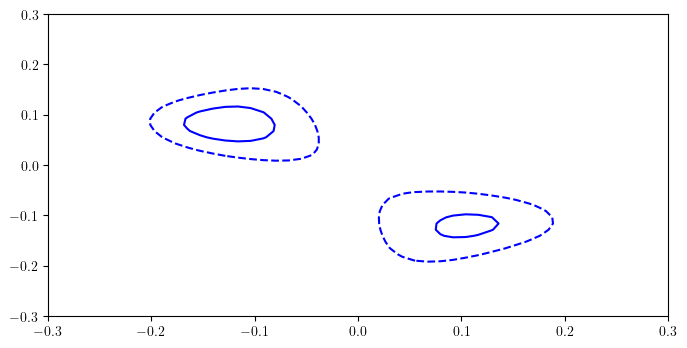

In [77]:
fig, ax = plt.subplots(1,1)
i = 2
dchi = marginalized_deltachi[i,:,:].reshape(9,9)
x = np.linspace(-eet,eet,9)
y = np.linspace(-eem,eem,9)
spl = RectBivariateSpline(x,y,dchi)
x_fine = np.linspace(x.min(),x.max(),50)
y_fine = np.linspace(y.min(),y.max(),50)
z = spl(x_fine, y_fine)
    

im = ax.contour(x_fine,y_fine,z, levels=[chi2.ppf(0.9,2),chi2.ppf(0.9973,2)],colors=['b','b'], linestyles = ['solid','dashed'])

In [140]:
from scipy.interpolate import interpn
x = np.linspace(-emt,emt,9)
y = np.linspace(-eet,eet,9)
z = np.linspace(-eem,eem,9)
x_fine = np.linspace(x.min(),x.max(),50)
y_fine = np.linspace(y.min(),y.max(),50)
z_fine = np.linspace(z.min(),z.max(),50)
X_fine, Y_fine, Z_fine = np.meshgrid(x_fine, y_fine, z_fine)
z_fine = interpn((x,y,z),marginalized_deltachi,(X_fine,Y_fine,Z_fine)).reshape(50,50,50)

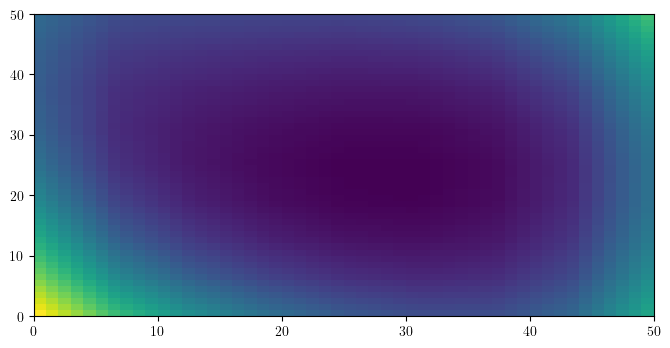

In [138]:
plt.pcolormesh(z_fine[20,:,:])

In [183]:
from matplotlib import animation
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

# Some 2D geo arrays to plot (time,lat,lon)
data = np.random.random_sample((20,90,360))
x_fine = np.linspace(x.min(),x.max(),50)
y_fine = np.linspace(y.min(),y.max(),50)
lons,lats = np.meshgrid(x_fine,y_fine)

x = np.linspace(-emt,emt,9)
y = np.linspace(-eet,eet,9)
z = np.linspace(-eem,eem,9)
x_fine = np.linspace(x.min(),x.max(),50)
y_fine = np.linspace(y.min(),y.max(),50)
z_fine = np.linspace(z.min(),z.max(),50)

X_fine, Y_fine, Z_fine = np.meshgrid(x_fine, y_fine, z_fine)
dchi_fine = interpn((x,y,z),marginalized_deltachi,(X_fine,Y_fine,Z_fine)).reshape(50,50,50)

mode = '3d'
if mode == '3d':
    ax = fig.add_subplot(111, projection='3d')
    X_fine, Y_fine = np.meshgrid(x_fine, y_fine)
# ims is a list of lists, each row is a list of artists to draw in the
# current frame; here we are animating three artists, the contour and 2 
# annotatons (title), in each frame
ims = []
for i in range(50):
    if mode == 'contour':
        im = ax.contour(x_fine,y_fine,dchi_fine[:,:,i], levels=[chi2.ppf(0.9,2),chi2.ppf(0.9973,2)],colors=['b','b'], linestyles = ['solid','dashed'])
        add_arts = im.collections
    elif mode == 'imshow':
        im = ax.pcolormesh(dchi_fine[i,:,:])
        add_arts = [im, ]
    elif mode == '3d':
        im = ax.plot_surface(X_fine, Y_fine, dchi_fine[i,:,:], alpha=0.8, cmap=cm.ocean)
        add_arts = [im, ]

    ims.append(add_arts)

ani = animation.ArtistAnimation(fig, ims, interval=1,repeat_delay=10, blit=False, repeat=True)
#ani = animation.ArtistAnimation(fig, ims)
## For saving the animation we need ffmpeg binary:
FFwriter = animation.FFMpegWriter()
ani.save('3d1.mp4', writer = FFwriter)

KeyboardInterrupt: 

In [153]:
p = im.collections[0].get_paths()[0]
v = p.vertices
x = v[:,0]
y = v[:,1]

In [163]:
X_fine.shape

(50, 50, 50)

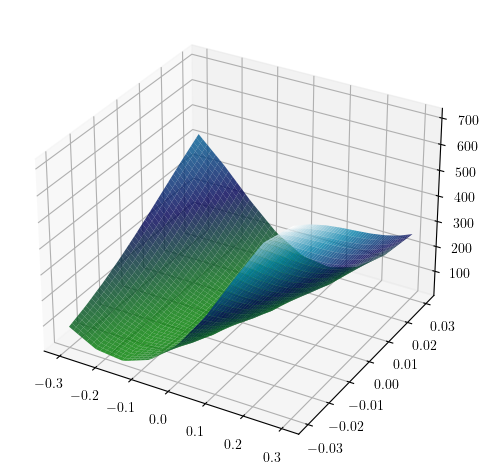

In [178]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
from matplotlib import cm
x = np.linspace(-emt,emt,9)
y = np.linspace(-eet,eet,9)
z = np.linspace(-eem,eem,9)

x_fine = np.linspace(x.min(),x.max(),50)
y_fine = np.linspace(y.min(),y.max(),50)
z_fine = np.linspace(z.min(),z.max(),50)

Y_fine, Z_fine = np.meshgrid(x_fine, y_fine)


fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111, projection='3d')


surf = ax.plot_surface(Z_fine, Y_fine, dchi_fine[:,:,40], alpha=0.8, cmap=cm.ocean)
# cset = ax.contourf(Z_fine, Y_fine, dchi_fine[0,:,:], zdir='z', offset=np.min(Z), cmap=cm.ocean)
# cset = ax.contourf(Z_fine, Y_fine, dchi_fine[0,:,:], zdir='x', offset=-5, cmap=cm.ocean)
# cset = ax.contourf(Z_fine, Y_fine, dchi_fine[0,:,:], zdir='y', offset=5, cmap=cm.ocean)